# Randomized Response

## Old release functions

In [1]:
rm(list=ls())		# Remove any objects in memory
set.seed(123)

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))

sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}

## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}

## Differentially private mean release
meanRelease <- function(x, lower, upper, epsilon){
	n <- length(x)

	sensitivity <- (upper - lower)/n
	scale <- sensitivity / epsilon

	x.clipped <- clip(x, lower, upper)
	sensitiveValue <- mean(x.clipped)
	DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)

	return(list(release=DPrelease, true=sensitiveValue))
}

## Plot Randomized Response Mechanism 

pdf 
  2

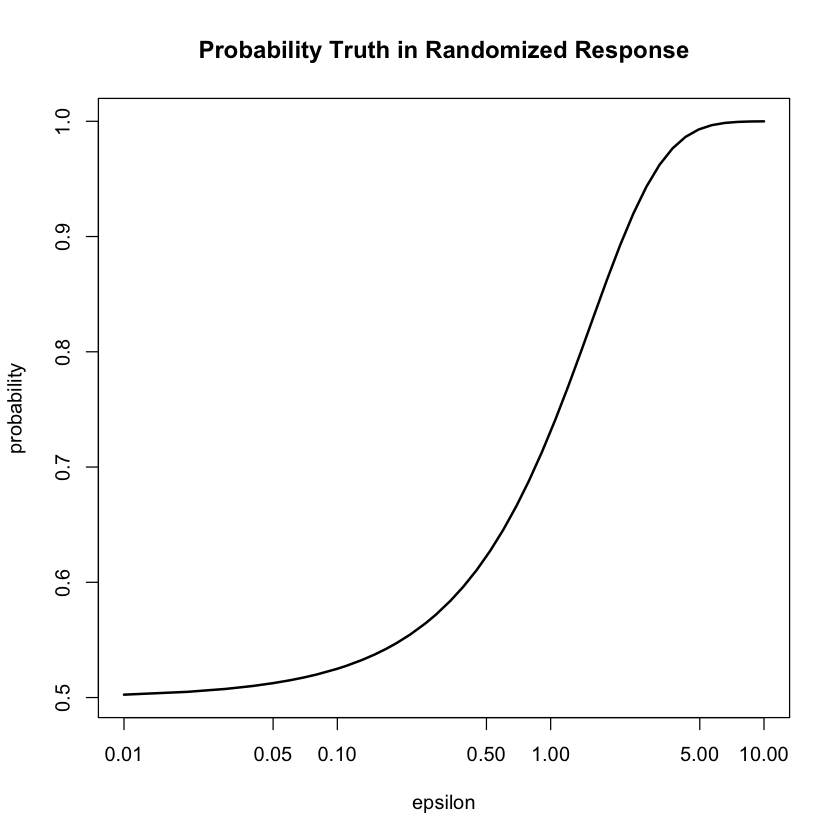

In [2]:
my.seq <- seq(from=log10(10), to=log10(0.01), length=50)     	# make evenly spaced in logarithmic space
ep.seq <- round(10^my.seq * 100) /100

probtrue <- exp(ep.seq)/(1 + exp(ep.seq)) 

par(mfcol=c(1,1))
plot(x=ep.seq, y=probtrue, type="l", log = "x", lwd=2, main="Probability Truth in Randomized Response", xlab="epsilon", ylab="probability")

## this is bounded in 0.5 and 1, because for low epsilon, it's as good as a coin flip

dev.copy2pdf(file="./figs/localMechanism.pdf")

## New Release Functions

In [39]:
localRelease <- function(x, values=c(-1,1), epsilon){ #every person runs this on their own machine. 
                                                      #x is a scalar, one person's individual value
	draw <- runif(n=1, min=0, max=1) 
	cutoff <- 1/(1+exp(epsilon)) # probability that i want to flip the value, less than 1/2
    if(draw<cutoff){
#         if x = 1, vector is F, T
#         if x = -1, vector is T, F
        to.return <- values[!values%in%x]
        return(to.return)
    }
    else{
        return(x)
    }
}

correction <- function(release, epsilon){
	inflation <- (exp(epsilon) + 1)/(exp(epsilon) - 1)
	expectation <- mean(release * inflation)
	return(expectation)
} # this is just post processing -- you need epsilon to calculate the correction factor

In [40]:
llik <- function(b, data, epsilon){ # likelihood of point b given some dataset and epsilon
	p <- 1/(1 + exp(-b))             	# Transform unconstrained b into 0<p<1 ### this is pi

	values <- sort(unique(data))        # Transform dichotomous data into z \in {0,1}
	z <- rep(0, length(data))
	z[data==values[2]] <- 1

	ptrue <- exp(epsilon)/(1+exp(epsilon))
	pfalse <- 1 - ptrue  # Or 1/(1-exp(epsilon))

	# Here's the log likelihood function as a row by row calculation
	llik <- sum(z)  * log(ptrue * p  + pfalse * (1-p)) + sum(1-z) * log((1-p) * ptrue + p * pfalse)    # this is a sum(z) sum(1-z) just to make the computation easier
	llik <- -1 * sum(llik)    			# Note optim performs minimization

	return(llik)
}

## Simulation

In [42]:
# Parameters
myn <- 1000
myepsilon <- 0.5

# Simulate dataset
mydata<-rbinom(n=myn, size=1, prob=0.3)
mydata[mydata==0] <- -1
true <- mean(mydata)

# Release each observation by RR
release <- rep(NA, myn)
for(i in 1:myn){
    release[i] <- localRelease(x=mydata[i], values=c(-1,1), epsilon=myepsilon)
}

# Correct expectation by inflation
expectation <- correction(release=release, epsilon=myepsilon)

# Correct expectation by Max.Likelihood
startparams <- -1

#output <- optim(par=startparams, fn=llik, data=mydata, epsilon=myepsilon, method="BFGS")  # Alt optimizer
output <- nlm(p=startparams, f=llik, data=release, epsilon=myepsilon, stepmax=0.1)

maxlik.p <- 1/(1+exp(-1* output$estimate))

maxlik.mean <- maxlik.p * max(mydata) + (1-maxlik.p) * min(mydata)


cat(paste("Mean of data:       ", mean(mydata), "\n"))
cat(paste("Mean of DP release: ", mean(release), "\n"))
cat(paste("Mean corrected:     ", expectation, "\n"))
cat(paste("MaxLikelihood mean: ", maxlik.mean, "\n"))

# log likelihood functions have lower MSE but are biased
# this does require data to be -1, +1 

# correcting for measurement error here in this mean corrected bit
# note that this is a lot easier in the local model, since th

Mean of data:        -0.396 
Mean of DP release:  -0.114 
Mean corrected:      -0.46546065081839 
MaxLikelihood mean:  -0.465461441070175 


In [37]:
(expectation)

[1] -0.5471204

In [19]:
# mean(release)

In [31]:
## Show loglikelihood surface

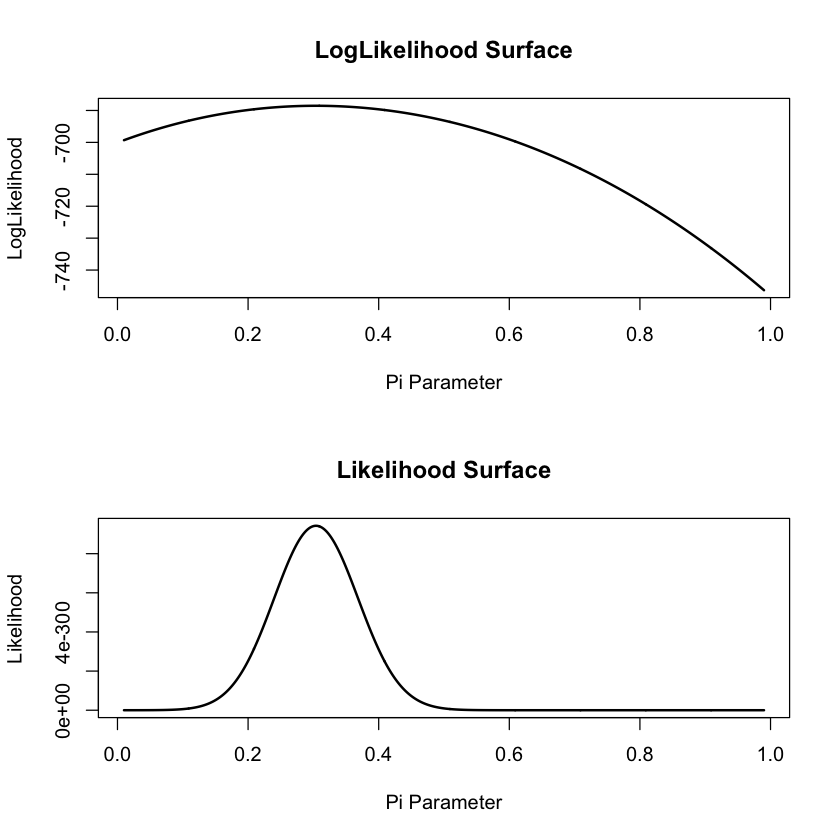

In [32]:

lik <- function(b, data, epsilon){
	p <- 1/(1 + exp(-b))             	# Transform unconstrained b into 0<p<1
	values <- sort(unique(data))        # Transform dichotomous data into z \in {0,1}
	z <- rep(0, length(data))
	z[data==values[2]] <- 1
	ptrue <- exp(epsilon)/(1+exp(epsilon))
	pfalse <- 1 - ptrue  # Or 1/(1-exp(epsilon))
	# Here's the likelihood function 
	lik <- -1*( p * ptrue + (1-p) * pfalse)^(sum(z)) * ((1-p) * ptrue + p * pfalse)^(sum(1-z))
	return(lik)
}



p.seq <- seq(from=.01, to=.99, by=.001)     # These are the probabilities we want to find the llikelihood of
b.seq <- -log(p.seq^{-1} - 1)              # These are the inverse transformations

y.lik <- y.llik <- rep(NA, length(p.seq))
for(i in 1:length(p.seq)){
	y.llik[i] <- -1*llik(b=b.seq[i], data=release, epsilon=myepsilon)
	y.lik[i] <- -1*lik(b=b.seq[i], data=release, epsilon=myepsilon)
}

par(mfcol=c(2,1))
plot(x=p.seq, y=y.llik, type="l", lwd=2, main="LogLikelihood Surface", xlab="Pi Parameter", ylab="LogLikelihood")
plot(x=p.seq, y=y.lik, type="l", lwd=2, main="Likelihood Surface", xlab="Pi Parameter", ylab="Likelihood")

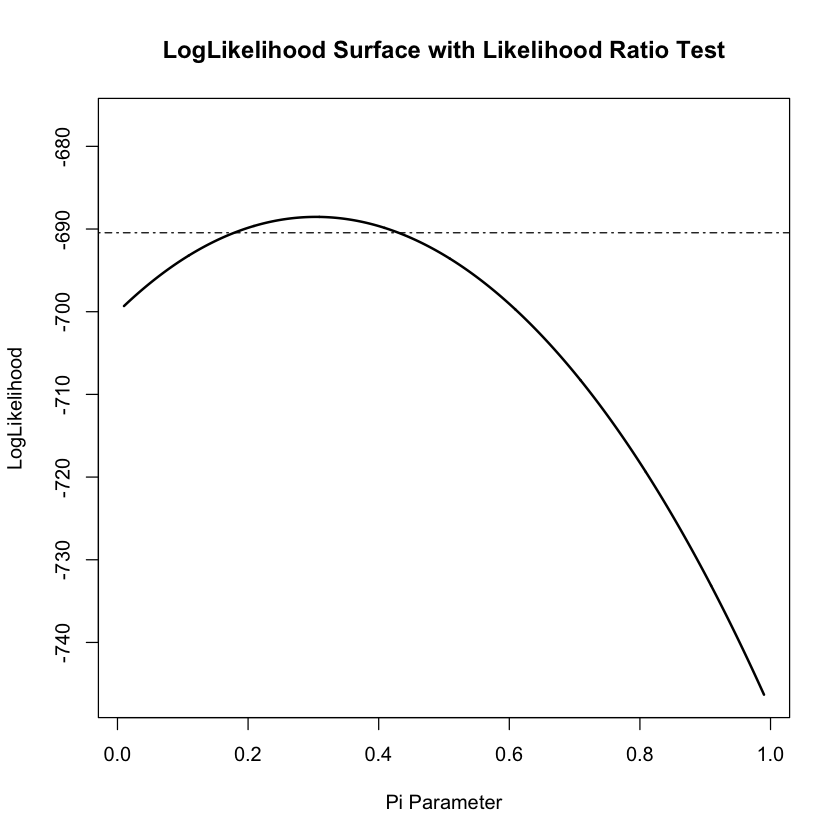

In [33]:
all.ylim <- c(min(y.llik), 1.2*max(y.llik)  - 0.2*min(y.llik))
plot(x=p.seq, y=y.llik, type="l", lwd=2, main="LogLikelihood Surface with Likelihood Ratio Test", ylim=all.ylim, xlab="Pi Parameter", ylab="LogLikelihood")
test.statistic=max(y.llik) - qchisq(0.95, df=1)/2

abline(h=test.statistic,lty=4)

# wilks test - ratio of lof likelihoods is a test statistic 


## Repeated Simulations

[1] 0.514


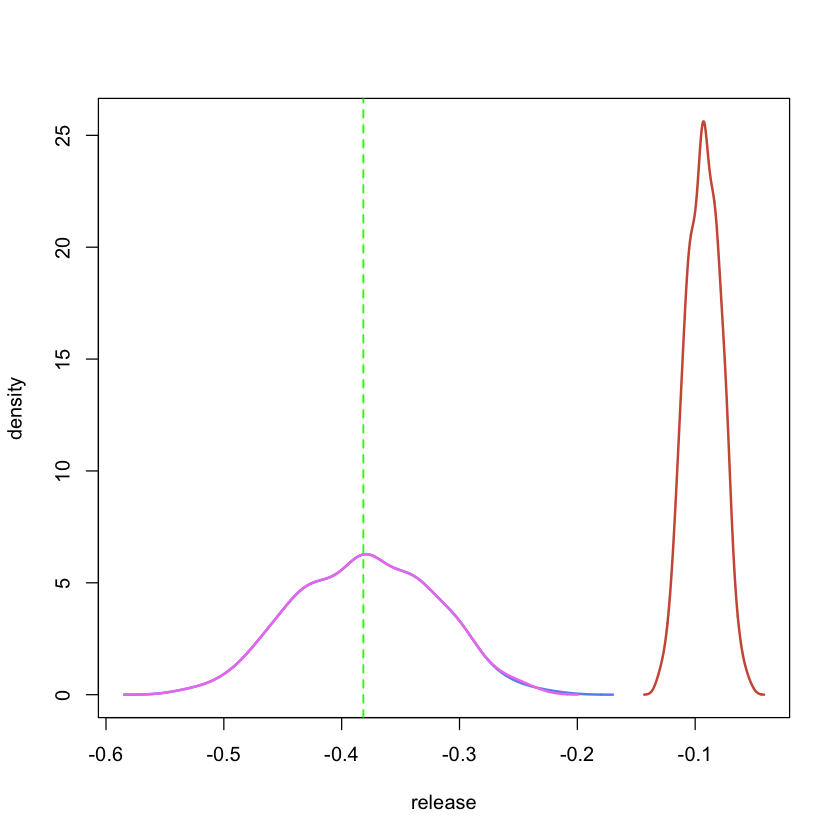

In [34]:
myn <- 5000
myepsilon <- 0.5

mydata<-rbinom(n=myn, size=1, prob=0.3)
mydata[mydata==0] <- -1
true <- mean(mydata)
# only draw data once, so as to not introduce sampling error

nsims <- 500
history <- matrix(NA, nrow=nsims, ncol=4)
release <- rep(NA, myn)

for(j in 1:nsims){
	for(i in 1:myn){
		release[i] <- localRelease(x=mydata[i], values=c(-1,1), epsilon=myepsilon)
	}

	expectation <- correction(release=release, epsilon=myepsilon)

	startparams <- -1
	output <- nlm(p=startparams, f=llik, data=release, epsilon=myepsilon, stepmax=0.1)

	maxlik.p <- 1/(1+exp(-1* output$estimate))

	maxlik.mean <- maxlik.p * max(mydata) + (1-maxlik.p) * min(mydata)

	laplace.release <- meanRelease(x=mydata, lower=-1, upper=1, epsilon=myepsilon)

	history[j,1] <- mean(release)
	history[j,2] <- expectation
	history[j,3] <- maxlik.mean
	history[j,4] <- laplace.release$release
}

dens.release <- density(history[,1])
dens.exp <- density(history[,2])
dens.maxlik <- density(history[,3])
dens.laplace <- density(history[,4])


all.ylim <- c(min(c(dens.release$y, dens.exp$y, dens.maxlik$y)), max(c(dens.release$y, dens.exp$y, dens.maxlik$y)))
all.xlim <- c(min(c(true, dens.release$x, dens.exp$x, dens.maxlik$x)), max(c(true, dens.release$x, dens.exp$x, dens.maxlik$x)))
all.lwd <- 2
col.seq <- c("coral3", "darkolivegreen3", "cornflowerblue", "violet")

plot(x=dens.release$x, y=dens.release$y, type="l", lwd=all.lwd, col=col.seq[1],  ylim=all.ylim, xlim=all.xlim, xlab="release", ylab="density")
lines(x=dens.exp$x, y=dens.exp$y, type="l", lwd=all.lwd, col=col.seq[3])
lines(x=dens.maxlik$x, y=dens.maxlik$y, type="l", lwd=all.lwd, col=col.seq[4])
abline(v=true, lty=2, lwd=1.5, col="green")

print(mean(history[,2]>true))

Multiply the DP release by some factor (c), so the variance of the corrected data is $c^2$

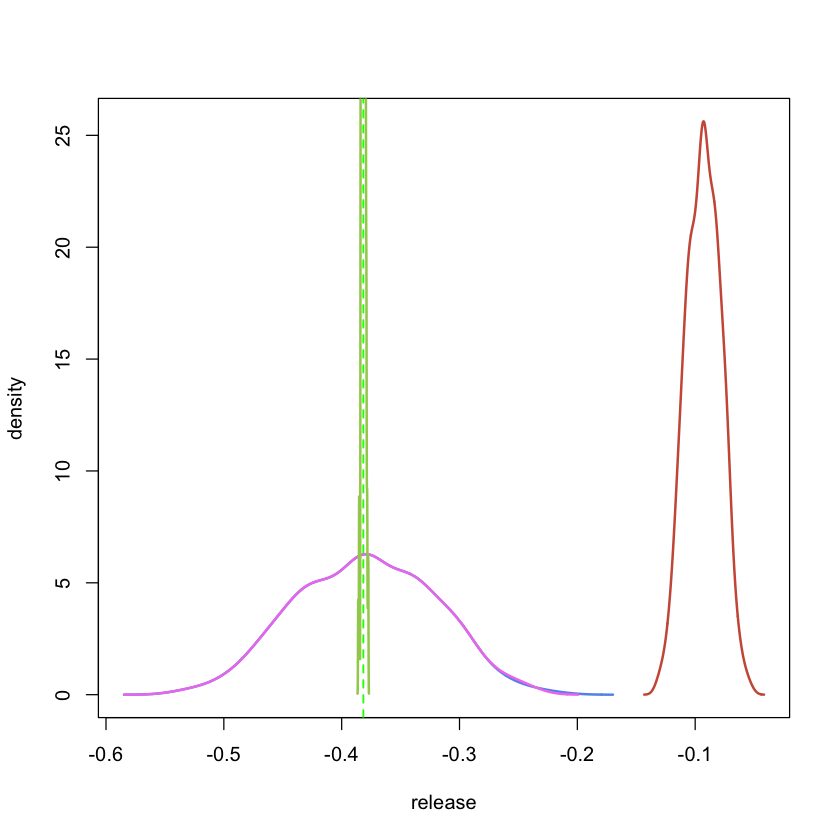

In [35]:
plot(x=dens.release$x, y=dens.release$y, type="l", lwd=all.lwd, col=col.seq[1],  ylim=all.ylim, xlim=all.xlim, xlab="release", ylab="density")
lines(x=dens.exp$x, y=dens.exp$y, type="l", lwd=all.lwd, col=col.seq[3])
lines(x=dens.maxlik$x, y=dens.maxlik$y, type="l", lwd=all.lwd, col=col.seq[4])
abline(v=true, lty=2, lwd=1.5, col="green")
lines(x=dens.laplace$x, y=dens.laplace$y, type="l", lwd=all.lwd, col=col.seq[2])

## Show utility over sample size 

Time elapsed: 1.30515055259069

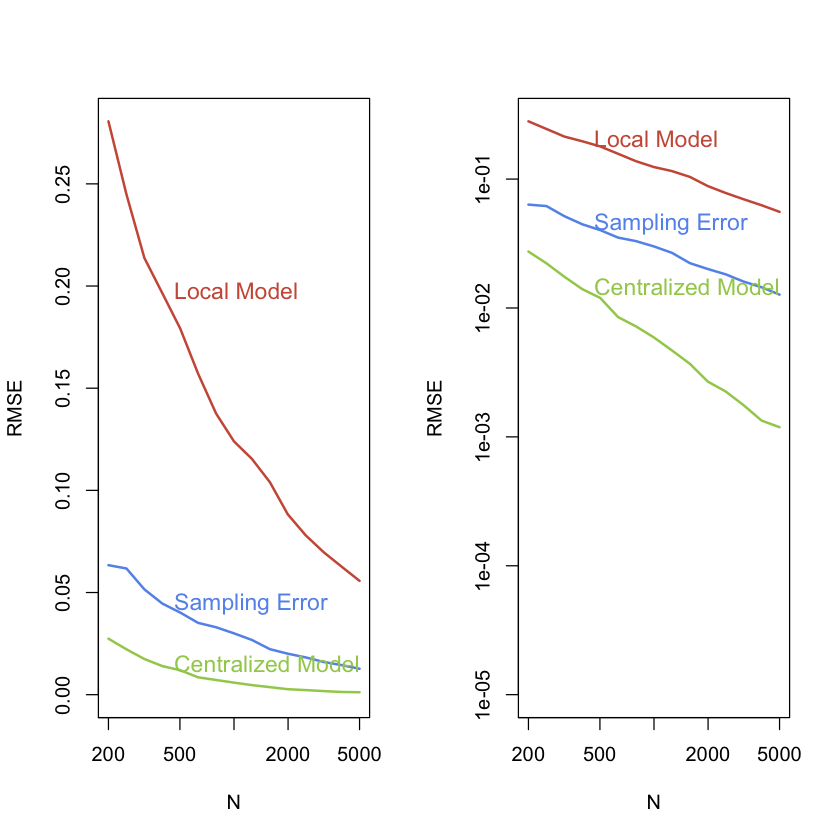

In [36]:


aa <- Sys.time()

my.seq <- seq(from=log10(200), to=log10(5000), length=15)  	# make evenly spaced in logarithmic space
n.seq  <- round(10^my.seq)                                 	# round to integers

myepsilon <- 0.5
mypi <- 0.3
population.true <- mypi*1 + (1-mypi)*(-1)

nsims <- 1000
history <- matrix(NA, nrow=length(n.seq), ncol=4)

for(i in 1:length(n.seq)){
	release <- rep(NA,n.seq[i])
	error.local <- error.laplace <- error.sampling <- NULL

	for(j in 1:nsims){
		mydata<-rbinom(n=n.seq[i], size=1, prob=mypi)
		mydata[mydata==0] <- -1
		true <- mean(mydata)

		for(k in 1:n.seq[i]){
			release[k] <- localRelease(x=mydata[k], values=c(-1,1), epsilon=myepsilon)
		}
		laplace <- meanRelease(x=mydata, lower=-1, upper=1, epsilon=myepsilon)

		error.local  <- c(error.local, true - correction(release=release, epsilon=myepsilon) )
		error.laplace <- c(error.laplace, true - laplace$release)
		error.sampling <- c(error.sampling, true - population.true)

	}
	history[i,1] <- n.seq[i]
	history[i,2] <- sqrt(mean(error.local^2))
	history[i,3] <- sqrt(mean(error.laplace^2))
	history[i,4] <- sqrt(mean(error.sampling^2))

}


par(mfcol=c(1,2))
all.ylim <- c(0.00001, max(history[,2:4]))
col.seq <- c("coral3", "darkolivegreen3", "cornflowerblue")
all.lwd <- 2
all.cex <- 1.15
xloc <- round(length(n.seq)*0.3)

plot(x=history[,1], y=history[,2], ylim=all.ylim, type="l", log="x", lwd=all.lwd, ylab="RMSE", xlab="N", col=col.seq[1])
lines(x=history[,1], y=history[,3], lwd=all.lwd, col=col.seq[2])
lines(x=history[,1], y=history[,4], lwd=all.lwd, col=col.seq[3])

text(x=history[xloc,1], y=history[xloc,2], label="Local Model", col=col.seq[1], pos=4, cex=all.cex)
text(x=history[xloc,1], y=history[xloc,3], label="Centralized Model", col=col.seq[2], pos=4, cex=all.cex)
text(x=history[xloc,1], y=history[xloc,4], label="Sampling Error", col=col.seq[3], pos=4, cex=all.cex)

plot(x=history[,1], y=history[,2], ylim=all.ylim, type="l", log="xy", lwd=all.lwd, ylab="RMSE", xlab="N", col=col.seq[1])
lines(x=history[,1], y=history[,3], lwd=all.lwd, col=col.seq[2])
lines(x=history[,1], y=history[,4], lwd=all.lwd, col=col.seq[3])

text(x=history[xloc,1], y=history[xloc,2], label="Local Model", col=col.seq[1], pos=4, cex=all.cex)
text(x=history[xloc,1], y=history[xloc,3], label="Centralized Model", col=col.seq[2], pos=4, cex=all.cex)
text(x=history[xloc,1], y=history[xloc,4], label="Sampling Error", col=col.seq[3], pos=4, cex=all.cex)

bb<- Sys.time()

cat(paste("Time elapsed:", bb-aa))

## Build Example for Histogram

Warning message in DPrelease[i] <- localRelease(sensitiveValue[i], values = c(0, :
“number of items to replace is not a multiple of replacement length”Warning message in DPrelease[i] <- localRelease(sensitiveValue[i], values = c(0, :
“number of items to replace is not a multiple of replacement length”Warning message in DPrelease[i] <- localRelease(sensitiveValue[i], values = c(0, :
“number of items to replace is not a multiple of replacement length”Warning message in DPrelease[i] <- localRelease(sensitiveValue[i], values = c(0, :
“number of items to replace is not a multiple of replacement length”Warning message in DPrelease[i] <- localRelease(sensitiveValue[i], values = c(0, :
“number of items to replace is not a multiple of replacement length”Warning message in DPrelease[i] <- localRelease(sensitiveValue[i], values = c(0, :
“number of items to replace is not a multiple of replacement length”Warning message in DPrelease[i] <- localRelease(sensitiveValue[i], values = c(0, :
“number of 

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not a multiple of replacement length”Warning message in out1[i] <- integerHistogramRelease(x = data1[i], lower = 1, upper = 16, :
“number of items to replace is not

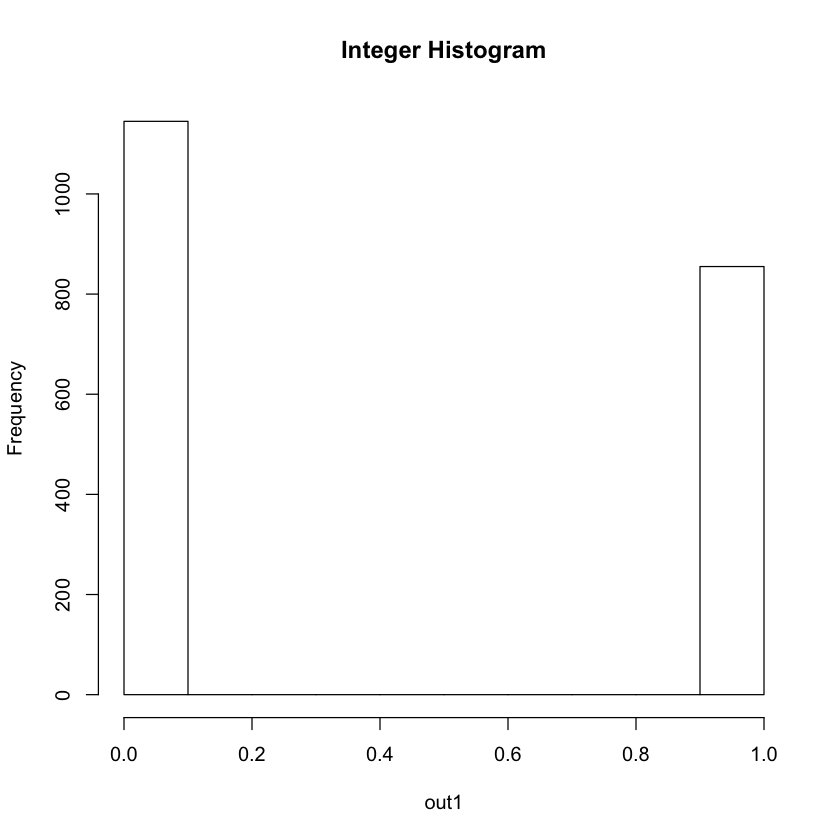

In [39]:

library("foreign")
PUMSdata <- read.csv(file="../../data/FultonPUMS5full.csv")   

data <- PUMSdata$educ    		# variable for means

## Sample with replacement from a vector
bootstrap <- function(x, y=NULL, n){
	index <- sample(x=1:length(x), size=n, replace=TRUE) 

	if(is.null(y)){
		return(x[index])
	}else{
		return(list(x=x[index], y=y[index]))
	}
}

showHist <- function(release, main="Histogram"){

	semi.blue <- rgb(0,90,239,150,maxColorValue=255)          # Slightly transparent colors
	semi.red  <- rgb(239,90,0,150,maxColorValue=255)

	DPrelease <- release$release
	codebook <- release$codebook
	true <- release$true

	allylim <- c(min(c(DPrelease,true), na.rm = TRUE), max(c(DPrelease, true), na.rm = TRUE))
	granularity <- (max(codebook) - min(codebook))/(length(codebook)-1)

	allxlim <- c(min(codebook) - 0.5*granularity, max(codebook + 0.5*granularity))

	# If stability threshold would be off the graph, extend range of graph
    if(!is.null(release$threshold)){
    	if(release$threshold>allylim[2]){
    		allylim[2]<-release$threshold
    	}
    }

    # Build empty plot
	plot.new()
	plot.window( xlim=allxlim, ylim=allylim)
	title(main = main)
	axis( side=1 )
	axis( side=2 )

	tiny <- granularity*0.03 # slight spacing between bars
	overlap <- granularity*0.2 # some small overlap between sensitive and DP values

	for(i in 1:length(codebook)){
		rect(xleft=codebook[i]-overlap, ybottom=0, xright=codebook[i]+0.5*granularity-tiny, ytop=true[i], col=semi.red)
		rect(xleft=codebook[i]-0.5*granularity+tiny, ybottom=0, xright=codebook[i]+overlap, ytop=DPrelease[i], col=semi.blue)
	}

	# If present, show stability threshold
	if(!is.null(release$threshold)){
		abline(h=release$threshold, col="black", lty=2, lwd=1.5)
	}
}



## Differentially private histogram for integers
integerHistogramRelease <- function(x, lower, upper, nbins=0, epsilon){ # x is a scalar
	n <- length(x)
	if(nbins==0){
		lower <- floor(lower)
		upper <- ceiling(upper)
		bins <- lower:upper   
        nbins <- length(bins)
    }

    x.clipped <- clip(x=x, lower=lower, upper=upper)

	sensitivity <- 2
	scale <- sensitivity / epsilon

	sensitiveValue <- DPrelease <- rep(NA,nbins)
	for(i in 1:length(bins)){
		sensitiveValue[i] <- sum(x.clipped==bins[i])
        
        DPrelease[i] <- localRelease(sensitiveValue[i], values=c(0,1), epsilon = epsilon/2 )
# 		DPrelease[i] <- sensitiveValue[i] + rlap(mu=0, b=scale, size=1)
	}

	return(list(release=DPrelease, true=sensitiveValue, codebook=bins))
}


# ## CENTRALIZED MODEL 
# Differentially private histogram for integers
# integerHistogramRelease <- function(x, lower, upper, nbins=0, epsilon){
# 	n <- length(x)
# 	if(nbins==0){
# 		lower <- floor(lower)
# 		upper <- ceiling(upper)
# 		bins <- lower:upper   
#         nbins <- length(bins)
#     }

#     x.clipped <- clip(x=x, lower=lower, upper=upper)

# 	sensitivity <- 2
# 	scale <- sensitivity / epsilon

# 	sensitiveValue <- DPrelease <- rep(NA,nbins)
# 	for(i in 1:length(bins)){
# 		sensitiveValue[i] <- sum(x.clipped==bins[i])
# 		DPrelease[i] <- sensitiveValue[i] + rlap(mu=0, b=scale, size=1)
# 	}

# 	return(list(release=DPrelease, true=sensitiveValue, codebook=bins))
# }

nboot <- 2000
data1 <- bootstrap(data, n=nboot)

out1 <- integerHistogramRelease(x=data1, lower=1, upper=16, epsilon=0.5)


out1 <- rep(NA, nboot)
for(i in 1:nboot){
	out1[i] <- integerHistogramRelease(x=data1[i], lower=1, upper=16, epsilon=0.5)$release
}


par(mfcol=c(1,1))
hist(out1, main="Integer Histogram")

